# **Prueba del modelo S2S con atención para clasificar comentarios de redes sociales sobre eventos educativos**

## 1. Lectura del corpus y los tokenizers

**Corpus: comentarios de redes sociales sobre eventos educativos**

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import pickle
from tensorflow.python.keras.preprocessing.text import Tokenizer

with open('/gdrive/MyDrive/DSRP/Data/corpus_dc', 'rb') as c_dc:
    corpus = pickle.load(c_dc)

with open('/gdrive/MyDrive/DSRP/Data/word_tokenizer', 'rb') as w_tok:
  word_tokenizer = pickle.load(w_tok)

with open('/gdrive/MyDrive/DSRP/Data/type_tokenizer', 'rb') as t_tok:
  type_tokenizer = pickle.load(t_tok)

comment_test_data = corpus['comments_te']
type_test_data = corpus['type_te']

num_words = len(word_tokenizer.word_index)
num_types = len(type_tokenizer.word_index)

print('Tokenización completada!')
print('Words : {:4d}'.format(num_words))
print('Intents1: {:4d}'.format(num_types))

Tokenización completada!
Words : 16499
Intents1:    2


## 2. Lectura de pesos y creación del modelo para prueba

In [ ]:
from tensorflow.python.keras import backend as K
import tensorflow as tf
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.layers import Input, Dropout, Bidirectional, Dense, AdditiveAttention, LSTM, CuDNNLSTM
#from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.python.keras.models import Model
#K.set_learning_phase(0)

def s2s_model(num_words, num_types, word_emb_dim, latent_dim, model_name):
  num_words = num_words + 1
  num_types = num_types + 1
  
  #---------
  # ENCODER
  #---------
  # Input layer
  enc_inp_w = Input(shape=(None,)) # (bs, t, 1)
  # Embedding layer
  w_emb_layer = Embedding(input_dim=num_words, output_dim=word_emb_dim, trainable=False, name='word_embedding')
  enc_emb_w = w_emb_layer(enc_inp_w) # (bs, t, we_dim)
  # Bidirectional LSTM layer
  forward_LSTM_encoder = CuDNNLSTM(latent_dim, return_state=True, return_sequences=True, name='forward_LSTM')
  backward_LSTM_encoder = CuDNNLSTM(latent_dim, return_state=True, return_sequences=True, go_backwards=True, name='backward_LSTM')
  BiLSTM_encoder = Bidirectional(forward_LSTM_encoder, backward_layer=backward_LSTM_encoder, name='BiLSTM')
  enc_out, forward_h, forward_c, backward_h, backward_c = BiLSTM_encoder(enc_emb_w) # (bs, t, 2*ld), (bs, 1, ld)...
  # Dense layer for states transfering
  dense_s0 = Dense(latent_dim, activation='tanh', name='dense_s0_init')
  dense_c0 = Dense(latent_dim, activation='tanh', name='dense_c0_init')
  dec_s_init = dense_s0(backward_h) # (bs, 1, ld)
  dec_c_init = dense_c0(backward_c) # (bs, 1, ld)
  dec_states_init = [dec_s_init, dec_c_init]

  #-----------
  # ATTENTION
  #-----------
  # Attention layer for type decoder
  dense_query_att_t = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_query_att_t')
  dense_key_att_t = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_key_att_t')
  attention_t = AdditiveAttention(name='Attention_t')
  query_att_t = dense_query_att_t(dec_s_init) # (bs, 1, 2*ld)
  key_att_t = dense_key_att_t(enc_out) # (bs, t, 2*ld)
  context_t = attention_t([query_att_t, enc_out, key_att_t]) # (bs, 1, 2*ld)

  #----------------
  # TYPE DECODER
  #----------------
  # LSTM layer
  LSTM_type_decoder = CuDNNLSTM(latent_dim, name='LSTM_type')
  dec_t_out = LSTM_type_decoder(context_t, initial_state=dec_states_init) # (bs, t, ld)
  # Dense layer with softmax activation
  type_dense_out_layer = Dense(num_types, activation='softmax', name='type_output')
  type_out = type_dense_out_layer(dec_t_out)

  model = Model(inputs=[enc_inp_w], outputs=[type_out])
  model.load_weights(model_name, by_name=True)

  K.set_learning_phase(0)

  # Encoder model
  encoder_model = Model(inputs=enc_inp_w, outputs=[enc_out, dec_s_init, dec_c_init])

  # Attention inputs
  enc_h_inp = Input(shape=(None, 2*latent_dim,))

  # Attention model for types
  dec_s_inp_t = Input(shape=(latent_dim,))
  query_att_t = dense_query_att_t(dec_s_inp_t) # (bs, 1, 2*ld)
  key_att_t = dense_key_att_t(enc_h_inp) # (bs, t, 2*ld)
  context_t = attention_t([query_att_t, enc_h_inp, key_att_t]) # (bs, 1, 2*ld)
  attention_type_model = Model(inputs=[dec_s_inp_t, enc_h_inp], outputs=context_t)

  # Type decoder model
  dec_c_inp_t = Input(shape=(latent_dim,))
  context_t_inp = Input(shape=(None, 2*latent_dim,))
  dec_t_out = LSTM_type_decoder(context_t_inp, initial_state=[dec_s_inp_t, dec_c_inp_t]) # (bs, t, ld)
  type_out = type_dense_out_layer(dec_t_out)
  type_decoder_model = Model(inputs=[dec_s_inp_t, dec_c_inp_t, context_t_inp], outputs=type_out)

  return encoder_model, attention_type_model, type_decoder_model

## 3. Prueba del modelo

In [ ]:
from math import log
import numpy as np

def beam_search_index(v):
  index = []
  vc = v.copy()
  for i in range(2):
    idx = np.argmax(vc, axis=-1)
    vc[0][0][idx[0][0]] = 0
    index.append(idx[0][0])
    
  return index

def predicting_type(model_param, comment, word_tokenizer, type_tokenizer):
  # ----------------------
  # Preparación de la data
  # ----------------------
  
  #comment = 'bos ' + comment + ' eos'
  comment_seq = np.array(word_tokenizer.texts_to_sequences([comment]))
  # -------------------------
  # Definición de los modelos
  # -------------------------
  encoder_model, attention_type_model, type_decoder_model = s2s_model(**model_param)
  # -------
  # Encoder
  # -------
  enc_h_inp, dec_s_inp, dec_c_inp = encoder_model.predict(comment_seq)
  
  # ------------
  # Type decoder
  # ------------
  # Type attention
  context_t_inp = attention_type_model.predict([dec_s_inp, enc_h_inp])
  # Decoding
  type_out = type_decoder_model.predict([dec_s_inp, dec_c_inp, context_t_inp])
  # Index
  ind_t = np.argmax(type_out, axis=-1)
  # Type
  print(ind_t[0])

  if ind_t[0] != 0:
      type_s = type_tokenizer.index_word[ind_t[0]]
  else:
      type_s = ''
  
  return type_s

1) Sacar métricas para el test
* comparación de las secuencias - BLEU / BLUE (OPCIONAL)
* matriz de confusión (clases: type-state)

In [ ]:
#!cp "drive/My Drive/Chatbot_COVID-19/seq2seq_attention_64bs128ld100epo64emb.h5" .
model_name = '/gdrive/My Drive/DSRP/vGPU_s2s_model_64bs128ld100epo320word_emb_2021-10-10.h5'
# emb_dim = 64
latent_dim = 128
word_emb_dim = 320
slot_emb_dim = 6

model_param = {'model_name': model_name, 'num_words': num_words, 'num_types': num_types, 
               'word_emb_dim': word_emb_dim, 'latent_dim': latent_dim}

In [ ]:
comment_test_data[2]

'muchos estudiantes no tienen internet no tienen celular o trabajan con el celular de su papa o mama los cuales llevan el celular a su trabajo y no pueden enviar sus evidencias'

In [ ]:
type_s_pred = predicting_type(model_param, comment_test_data[2], word_tokenizer, type_tokenizer)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:437: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


2


In [ ]:
comment_test_data_temp = comment_test_data
type_test_data_temp = type_test_data

In [ ]:
def evaluate_predict_type(comments, eval_model_param,
                          eval_word_tokenizer, eval_type_tokenizer):
  predicted_types = []
  
  for c in comments:
    type_s_pred = predicting_type(eval_model_param, c, eval_word_tokenizer, eval_type_tokenizer)
    predicted_types.append(type_s_pred)
  
  return  predicted_types
  
final_predicted_types = evaluate_predict_type(comment_test_data, model_param, word_tokenizer, type_tokenizer)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:437: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2


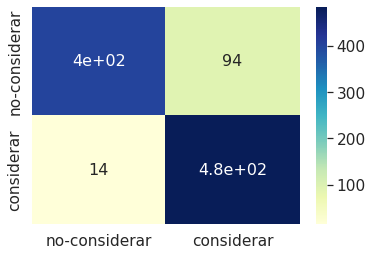

In [ ]:
# calculate Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

cm_type = confusion_matrix(type_test_data, final_predicted_types, labels=['no-considerar', 'considerar'])
df_cm_type = pd.DataFrame(cm_type, ['no-considerar', 'considerar'], ['no-considerar', 'considerar'])
sn.set(font_scale=1.4)
sn.heatmap(df_cm_type, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

model_f1 = f1_score(type_test_data, final_predicted_types, average='weighted')
model_precision = precision_score(type_test_data, final_predicted_types, average='weighted')
model_recall = recall_score(type_test_data, final_predicted_types, average='weighted')
model_accuracy = accuracy_score(type_test_data, final_predicted_types)

print(model_f1)
print(model_precision)
print(model_recall)
print(model_accuracy)

0.888682343932616
0.9020791498293544
0.8872255489021956
0.8872255489021956


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
comment_test_data[16]

' tranquila  aunque llevando un dolor de cabeza y de vista  tranquila con ganas de saber más de lo que vendrá'

In [ ]:
print(type_test_data[16])
print(final_predicted_types[16])

considerar



In [ ]:
comment_test_data[23]

'mucha salud para todos y que termine está pandemia'

In [ ]:
print(type_test_data[23])
print(final_predicted_types[23])

considerar
no-considerar


# 4. Comparación de métricas en el dataset de test

In [ ]:
list_word_emb_dim = [64, 128, 192, 256, 320]
list_acc_wed = [0.881, 0.903, 0.896, 0.895, 0.887]
list_prec_wed = [0.904, 0.910, 0.909, 0.920, 0.902]
list_f1_wed = [0.886, 0.903, 0.897, 0.905, 0.888]

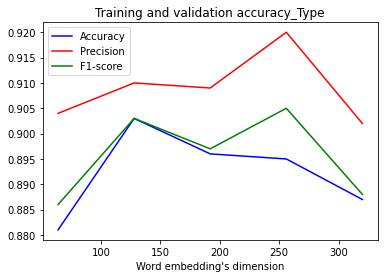

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_word_emb_dim, list_acc_wed, 'b', label='Accuracy')
plt.plot(list_word_emb_dim, list_prec_wed, 'r', label='Precision')
plt.plot(list_word_emb_dim, list_f1_wed, 'g', label='F1-score')
plt.title('Training and validation accuracy_Type')
plt.xlabel('Word embedding\'s dimension')
plt.legend()
plt.show()